<a href="https://colab.research.google.com/github/tina287/fianceHomework/blob/main/%E9%87%91%E8%9E%8D%E4%BD%9C%E6%A5%AD1023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件
from sklearn.metrics import mean_squared_error # 計算 mse 誤差
import matplotlib.pyplot as plt # 畫圖套件
import numpy as np # 數值計算套件

In [3]:
stock_id = "2330.tw"
# stock_id = "2357.tw"
# stock_id = "2317.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

'''抓取特定時間'''
# start = dt.datetime(2024, 1, 1)  # 指定的開始日期
# end = dt.datetime(2024, 6, 30)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
data = yf.download(stock_id, start=start, end=end).reset_index()

df = data.copy()
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-04-26,788.0,789.0,782.0,782.0,775.530762,32571247
1,2024-04-29,790.0,795.0,787.0,795.0,788.423218,26765837
2,2024-04-30,797.0,802.0,790.0,790.0,783.464539,39051972
3,2024-05-02,789.0,789.0,772.0,772.0,765.613403,40527228
4,2024-05-03,788.0,788.0,773.0,780.0,773.547302,29901556
...,...,...,...,...,...,...,...
114,2024-10-15,1050.0,1075.0,1050.0,1070.0,1070.000000,42850176
115,2024-10-16,1040.0,1070.0,1035.0,1045.0,1045.000000,52652149
116,2024-10-17,1050.0,1055.0,1030.0,1035.0,1035.000000,54173771
117,2024-10-18,1095.0,1100.0,1075.0,1085.0,1085.000000,85011961


In [4]:
df['Date'].head()

,Date
0,2024-04-26
1,2024-04-29
2,2024-04-30
3,2024-05-02
4,2024-05-03


In [5]:
# 不更動原始資料：
# 將原始資料複製出一份給統計學模型使用
df_stat = df.copy()  # 給統計模型使用的資料副本

In [6]:
# 將日期欄位轉為datetime格式
df_stat['Date'] = pd.to_datetime(df_stat['Date'])
# 將日期欄位設為索引
df_stat.set_index('Date', inplace=True)

df_stat

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-26,788.0,789.0,782.0,782.0,775.530762,32571247
2024-04-29,790.0,795.0,787.0,795.0,788.423218,26765837
2024-04-30,797.0,802.0,790.0,790.0,783.464539,39051972
2024-05-02,789.0,789.0,772.0,772.0,765.613403,40527228
2024-05-03,788.0,788.0,773.0,780.0,773.547302,29901556
...,...,...,...,...,...,...
2024-10-15,1050.0,1075.0,1050.0,1070.0,1070.000000,42850176
2024-10-16,1040.0,1070.0,1035.0,1045.0,1045.000000,52652149
2024-10-17,1050.0,1055.0,1030.0,1035.0,1035.000000,54173771


In [7]:
# 選擇收盤價作為預測目標
close_prices = df_stat['Close']

# 拆分資料分為訓練集(70%) 和測試集(30%)
train_size = int(len(close_prices) * 0.7)
train, test = close_prices[:train_size], close_prices[train_size:]

print(f"訓練集長度: {len(train)}")
print(f"測試集長度: {len(test)}")

訓練集長度: 83
測試集長度: 36


# ARIMA

In [8]:
from statsmodels.tsa.arima.model import ARIMA  # 引入 ARIMA 模型
from math import sqrt  # 引入數學根號
import warnings  # 用來忽略警告訊息（可選）
warnings.filterwarnings("ignore")  # 忽略警告訊息

# 優化 ARIMA 模型參數的函數
def optimize_arima(train, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    best_model = None
    # 使用迴圈迭代 p, d, q 組合找出最佳參數
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    # order=(p, d, q)：非季節性ARIMA部分的參數，p 代表自回歸項，d 代表差分階數，q 代表移動平均項。
                    model = ARIMA(train, order=(p, d, q))

                    # 模型擬合
                    model_fit = model.fit()
                    yhat = model_fit.forecast(steps=len(test))

                    # 計算誤差RMSE
                    error = sqrt(mean_squared_error(test, yhat))

                    # 比較當前誤差與最好模型的誤差，存取最好的模型
                    if error < best_score:
                        # 存取最低的誤差分數, 存取最好的 p, d, q 參數
                        best_score, best_cfg = error, (p, d, q)
                        # 存取最好的模型
                        best_model = model_fit
                except:
                    continue

    return best_cfg, best_model

# 定義 p, d, q 參數範圍
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

# 找出 ARIMA 模型最佳參數
best_cfg, best_model = optimize_arima(train, p_values, d_values, q_values)

# 印出最佳参数
print(f'最佳參數 {best_cfg}')

最佳參數 (5, 2, 1)


In [9]:
# 預測
yhat = best_model.forecast(steps=len(test))

# 計算誤差RMSE
rmse_optimized = sqrt(mean_squared_error(test, yhat))

# 印出誤差RMSE
print(f"RMSE: {rmse_optimized}")

RMSE: 37.58724090135811


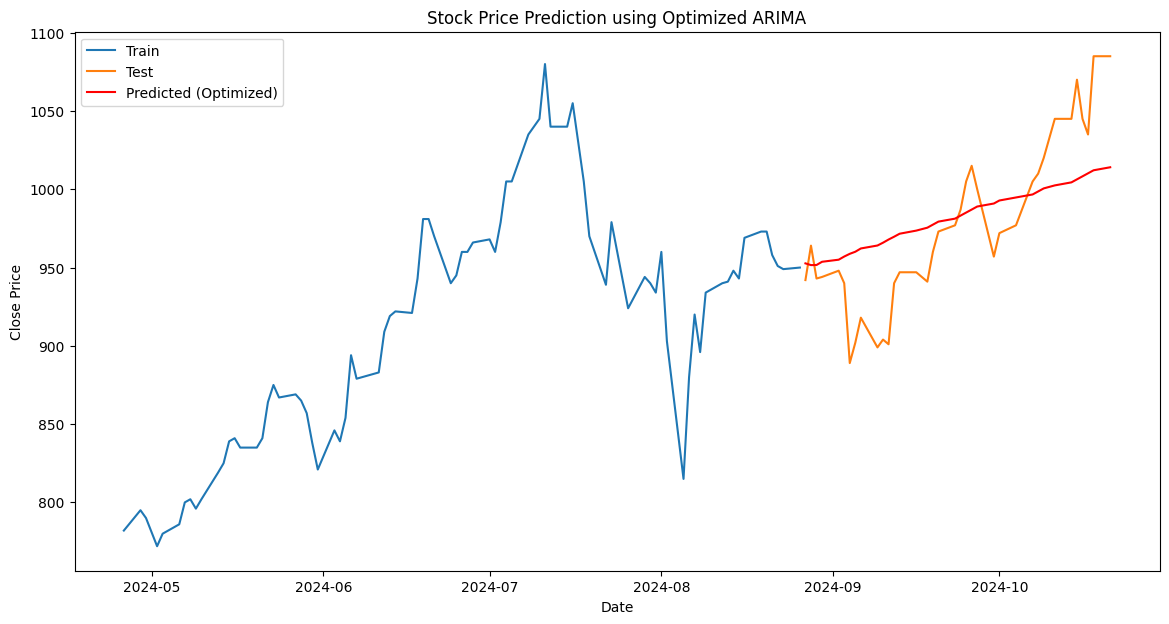

In [10]:
# 繪製折線圖
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, yhat, color='red', label='Predicted (Optimized)')
plt.title('Stock Price Prediction using Optimized ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 量化交易

[*********************100%***********************]  1 of 1 completed


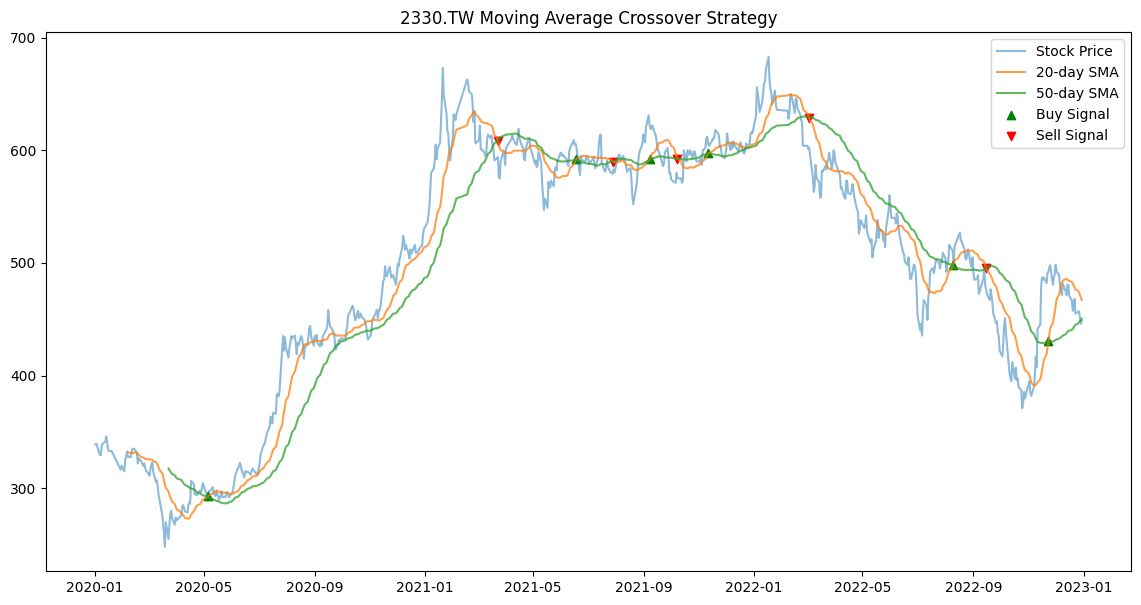

In [11]:
stock = "2330.TW"
df = yf.download(stock, start="2020-01-01", end="2023-01-01")

# 計算短期和長期的簡單移動平均線（SMA）
df['SMA_short'] = df['Close'].rolling(window=20).mean()  # 20天移動平均
df['SMA_long'] = df['Close'].rolling(window=50).mean()   # 50天移動平均

# 計算買入和賣出信號
df['Signal'] = 0  # 初始化信號欄位
df['Signal'][20:] = np.where(df['SMA_short'][20:] > df['SMA_long'][20:], 1, 0)  # 產生買賣信號
df['Position'] = df['Signal'].diff()  # 計算每次買入/賣出的位置變化

# 可視化策略
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Stock Price', alpha=0.5)
plt.plot(df['SMA_short'], label='20-day SMA', alpha=0.75)
plt.plot(df['SMA_long'], label='50-day SMA', alpha=0.75)
plt.scatter(df[df['Position'] == 1].index, df['SMA_short'][df['Position'] == 1], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(df[df['Position'] == -1].index, df['SMA_short'][df['Position'] == -1], marker='v', color='r', label='Sell Signal', alpha=1)
plt.title(f'{stock} Moving Average Crossover Strategy')
plt.legend(loc='best')
plt.show()